In [63]:
%%capture
!pip install pandas nltk scipy matplotlib

In [13]:
import pandas as pd
import re
import json

dataframe: pd.DataFrame = pd.read_csv("../resources/sampled_reviews_with_output_phi3_medium.csv")

In [14]:
dataframe.head(5)

,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,index,level_0
0,434.0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
1,3278.0,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
2,967.0,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN
3,1982.0,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983.0,"```json\n{\n ""sentiment"": ""positive"",\n ""re...",NaN,NaN
4,2902.0,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",NaN,NaN


In [36]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing_function: SmoothingFunction = SmoothingFunction()

ZERO_SCORE = ({
                  "review_score": .0,
                  "sentiment_score": .0,
                  "ner_score": {
                      "accuracy": .0,
                      "precision": .0,
                      "recall": .0,
                      "f1": .0
                  }
              }, .0)


def compute_bleu(reference: str, hypothesis: str) -> float:
    """
    It computes the BLEU score between hypothesis and reference.

    Arguments:
        hypothesis (list[str]): The hypothesis.
        reference (list[list[str]]): The reference.

    Return:
        The BLEU score.
    """
    return corpus_bleu([[reference.split()]], [hypothesis.split()], smoothing_function=smoothing_function.method1)


def evaluate(row: pd.DataFrame) -> (dict, float):
    ground_truth: dict = json.loads(row["json"])
    output: str = row["output"]
    groups = re.findall(pattern=r"(\{.*})", flags=re.DOTALL, string=output)
    if len(groups) != 1:
        return ZERO_SCORE

    group: str = groups[0]
    try:
        output_dict: dict = json.loads(group)
    except json.JSONDecodeError as e:
        print(str(e))
        return ZERO_SCORE

    review_score: float = compute_bleu(ground_truth["review"], output_dict["review"]) if "review" in output_dict else .0
    sentiment_score: float = 1.0 if "sentiment" in output_dict and output_dict["sentiment"] == ground_truth[
        "sentiment"] else 0.0

    ground_truth_entities: list[str] = ground_truth["entities"]
    score: dict = {
        "review_score": review_score,
        "sentiment_score": sentiment_score,
        "ner_score": {
            "accuracy": .0,
            "precision": .0,
            "recall": .0,
            "f1": .0
        }
    }
    if "entities" not in output_dict:
        return score, sum([review_score, sentiment_score, .0]) / 3.0
    
    detected_entities = output_dict["entities"] if "entities" in output_dict else []
    if len(detected_entities) == 0 and len(ground_truth_entities) == 0:
        score["ner_score"]["accuracy"] = 1.0
        score["ner_score"]["precision"] = 1.0
        score["ner_score"]["recall"] = 1.0
        score["ner_score"]["f1"] = 1.0
        return score, sum([review_score, sentiment_score, 1.0]) / 3.0

    false_negatives: int = 0  # Quelli che ci sono in GT, ma non nei detected
    false_positives: int = 0  # Quelli che sono stati individuati, ma non ci sono in GT
    true_positives: int = 0  # Quelli che sono stati correttamente individuati

    for ge in ground_truth_entities:
        ge_found: bool = False
        for de in detected_entities:
            if "label" not in de or "value" not in de or len(de.items()) != 2:
                continue
            label: str = de["label"]
            value: str = de["value"]
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if ge_found:
            true_positives += 1
        else:
            false_negatives += 1

    for de in detected_entities:
        if "label" not in de or "value" not in de or len(de.items()) != 2:
            false_positives += 1
            continue
        label: str = de["label"]
        value: str = de["value"]
        ge_found: bool = False
        for ge in ground_truth_entities:
            if label == ge["label"] and value == ge["value"]:
                ge_found = True
                break
        if not ge_found:
            false_positives += 1

    score["ner_score"]["accuracy"]: float = true_positives / (
                true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["precision"]: float = true_positives / (
            true_positives + false_positives) if true_positives + false_positives > 0 else .0
    score["ner_score"]["recall"]: float = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else .0
    score["ner_score"]["f1"] = 2 * (score["ner_score"]["precision"] * score["ner_score"]["recall"]) / (score["ner_score"]["precision"] + score["ner_score"]["recall"]) if (score["ner_score"]["precision"] + score["ner_score"]["recall"]) > 0 else .0

    return score, sum([review_score, sentiment_score, score["ner_score"]["f1"]]) / 3.0


In [44]:
dataframe["single_call_score"] = dataframe.apply(
    lambda row: evaluate(row)[1], axis=1)
dataframe["single_call_score_detail"] = dataframe.apply(
    lambda row: evaluate(row)[0], axis=1)
dataframe.drop(columns=["level_0", "index"], inplace=True)
dataframe.reset_index(inplace=True)
dataframe

Invalid control character at: line 11 column 19 (char 365)
Invalid control character at: line 3 column 380 (char 408)
Invalid control character at: line 11 column 19 (char 365)
Invalid control character at: line 3 column 380 (char 408)


,index,Unnamed: 0,review,sentiment,entities,json,progressive_index,output,single_call_score,single_call_score_detail
0,0,434.0,"1st watched 2/9/2008, 4 out of 10(Dir-J.S. Car...",negative,"[{'label': 'ORG', 'value': 'qwest'}, {'label':...","{""review"": ""1st watched 2/9/2008, 4 out of 10(...",435.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
1,1,3278.0,Following on directly from the last episode of...,positive,"[{'label': 'PERSON', 'value': 'Hacker'}, {'lab...","{""review"": ""Following on directly from the las...",3279.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.001166,"{'review_score': 0.0034988210954885095, 'senti..."
2,2,967.0,But at least this movie got what it deserved -...,negative,"[{'label': 'PERSON', 'value': 'Mike'}, {'label...","{""review"": ""But at least this movie got what i...",968.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.333610,"{'review_score': 0.000830176019450272, 'sentim..."
3,3,1982.0,A few buddies and myself have the strange hobb...,negative,"[{'label': 'PERSON', 'value': 'Larry Buchanan'...","{""review"": ""A few buddies and myself have the ...",1983.0,"```json\n{\n ""sentiment"": ""positive"",\n ""re...",0.000008,"{'review_score': 2.5074096666966153e-05, 'sent..."
4,4,2902.0,On a routine mission in Iraq a group of Delta ...,positive,"[{'label': 'ORG', 'value': 'Delta'}, {'label':...","{""review"": ""On a routine mission in Iraq a gro...",2903.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.001260,"{'review_score': 0.0037800365417970617, 'senti..."
5,5,4132.0,Mildly entertaining and self consciously cheez...,negative,"[{'label': 'PERSON', 'value': 'McClure'}]","{""review"": ""Mildly entertaining and self consc...",4133.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.334260,"{'review_score': 0.0027796844805889173, 'senti..."
6,6,3766.0,Style but no substance. Not as funny as it sho...,negative,"[{'label': 'PERSON', 'value': 'Barbarella'}, {...","{""review"": ""Style but no substance. Not as fun...",3767.0,"```json\n{\n ""sentiment"": ""positive"",\n ""re...",0.000000,"{'review_score': 0.0, 'sentiment_score': 0.0, ..."
7,7,520.0,Long trailer? whoever said that has got to be ...,positive,"[{'label': 'ORG', 'value': ""woo ping's""}, {'la...","{""review"": ""Long trailer? whoever said that ha...",521.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.000987,"{'review_score': 0.0029599772060911553, 'senti..."
8,8,2404.0,I checked this out at the Vancouver Internatio...,negative,[],"{""review"": ""I checked this out at the Vancouve...",2405.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.336472,"{'review_score': 0.009414809499409111, 'sentim..."
9,9,2113.0,First: I bought it at the video store. Second:...,negative,"[{'label': 'PERSON', 'value': 'Adam Sandler'},...","{""review"": ""First: I bought it at the video st...",2114.0,"```json\n{\n ""sentiment"": ""negative"",\n ""re...",0.334325,"{'review_score': 0.002973557232511178, 'sentim..."


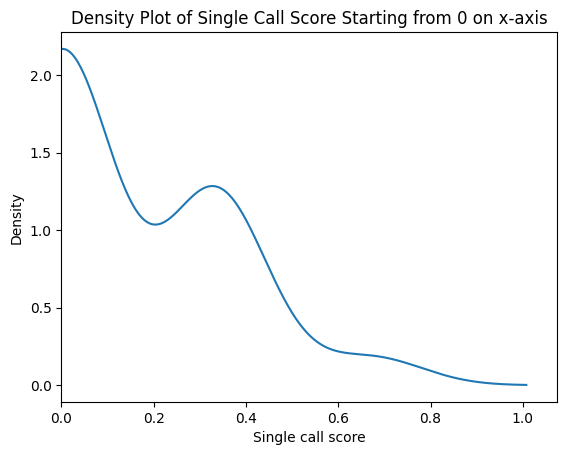

In [65]:
import matplotlib.pyplot as plt

ax = dataframe["single_call_score"].plot(kind="kde")

# Set the x-axis limit to start from 0
ax.set_xlim(0)

# Add labels and title
plt.xlabel('Single call score')
plt.ylabel('Density')
plt.title('Density Plot of Single Call Score Starting from 0 on x-axis')

# Show the plot
plt.show()

In [58]:
plotting_df = dataframe.melt(id_vars=["model_one_single_call_bleu", "model_one_multi_call_bleu"])
plotting_df = plotting_df[plotting_df["variable"] == "index"]
plotting_df.head()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['model_one_single_call_bleu', 'model_one_multi_call_bleu']"